In [11]:
# Install required packages if not available
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
        print(f"{package} module is already installed")
        return True
    except ImportError:
        try:
            print(f"Installing {package} module...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"{package} module installed successfully")
            return True
        except Exception as e:
            print(f"Failed to install {package}: {e}")
            return False

# Install required packages
install_package("requests")
install_package("folium")

requests module is already installed


🔹 Step 1: Fetch & Preprocess Earthquake Data

In [6]:
import pandas as pd
import json
from urllib.request import urlopen

# USGS API (your link)
url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2022-04-01&endtime=2025-01-01&minmagnitude=4.5"

# Fetch data using urllib (built into Python)
try:
    with urlopen(url) as response:
        data = json.loads(response.read())
    print("Data fetched successfully using urllib")
except Exception as e:
    print(f"Error fetching data: {e}")
    # Fallback: use a smaller dataset
    url_small = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2024-01-01&endtime=2024-02-01&minmagnitude=4.5"
    with urlopen(url_small) as response:
        data = json.loads(response.read())
    print("Using smaller dataset (1 month) as fallback")

# Extract features from GeoJSON
features = data['features']

# Create lists to store earthquake data
earthquake_data = []

for feature in features:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    
    earthquake_info = {
        'time': pd.to_datetime(properties['time'], unit='ms'),
        'magnitude': properties['mag'],
        'place': properties['place'],
        'longitude': coordinates[0],
        'latitude': coordinates[1],
        'depth': coordinates[2]
    }
    earthquake_data.append(earthquake_info)

# Create DataFrame
df = pd.DataFrame(earthquake_data)

print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMagnitude range: {df['magnitude'].min():.1f} - {df['magnitude'].max():.1f}")
print(f"\nTime range: {df['time'].min()} to {df['time'].max()}")

# Basic statistics
print(f"\nBasic Statistics:")
print(df.describe())

Data fetched successfully using urllib
                     time  magnitude  \
0 2024-12-31 23:13:20.048        5.0   
1 2024-12-31 22:32:02.906        4.6   
2 2024-12-31 20:09:41.043        5.1   
3 2024-12-31 19:46:28.183        4.6   
4 2024-12-31 19:18:38.342        4.8   

                                      place  longitude  latitude  depth  
0                  49 km W of Puerto, Chile   -70.6231  -20.1826  35.00  
1     86 km ENE of Kinablangan, Philippines   127.2640    8.0127  10.00  
2  124 km ESE of Kandrian, Papua New Guinea   150.5771   -6.6675  10.00  
3       88 km S of Kokopo, Papua New Guinea   152.1814   -5.1354  60.51  
4               14 km NW of Āwash, Ethiopia    40.0771    9.0825  10.00  

Dataset shape: (19619, 6)

Data types:
time         datetime64[ns]
magnitude           float64
place                object
longitude           float64
latitude            float64
depth               float64
dtype: object

Magnitude range: 4.5 - 7.8

Time range: 2022-04-01 01

🔹 Step 2: Apply DBSCAN


Cluster counts:


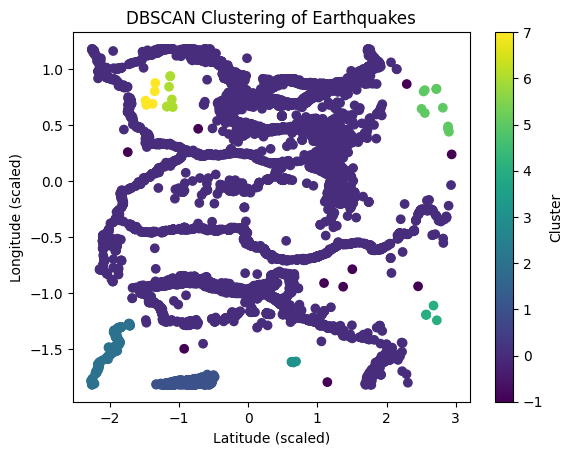

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

x = df[['latitude', 'longitude']].values
x_scaled = StandardScaler().fit_transform(x)

dbscan = DBSCAN(eps=0.2, min_samples=5)
clusters = dbscan.fit_predict(x_scaled)

df['cluster'] = clusters
print("\nCluster counts:")

plt.scatter(x_scaled[:, 0], x_scaled[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Latitude (scaled)')
plt.ylabel('Longitude (scaled)')
plt.title('DBSCAN Clustering of Earthquakes')
plt.colorbar(label='Cluster')
plt.show()

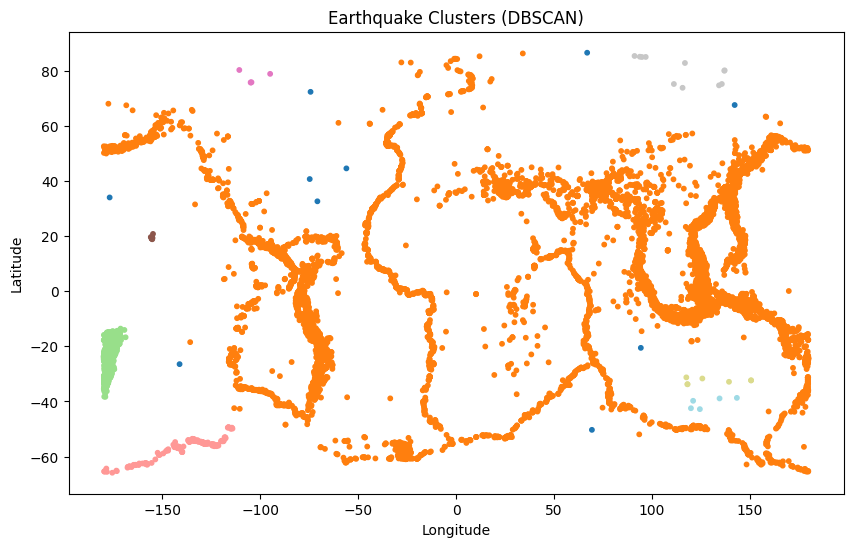

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='tab20', s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Earthquake Clusters (DBSCAN)")
plt.show()


Folium not available (No module named 'folium'). Creating enhanced static visualization instead...


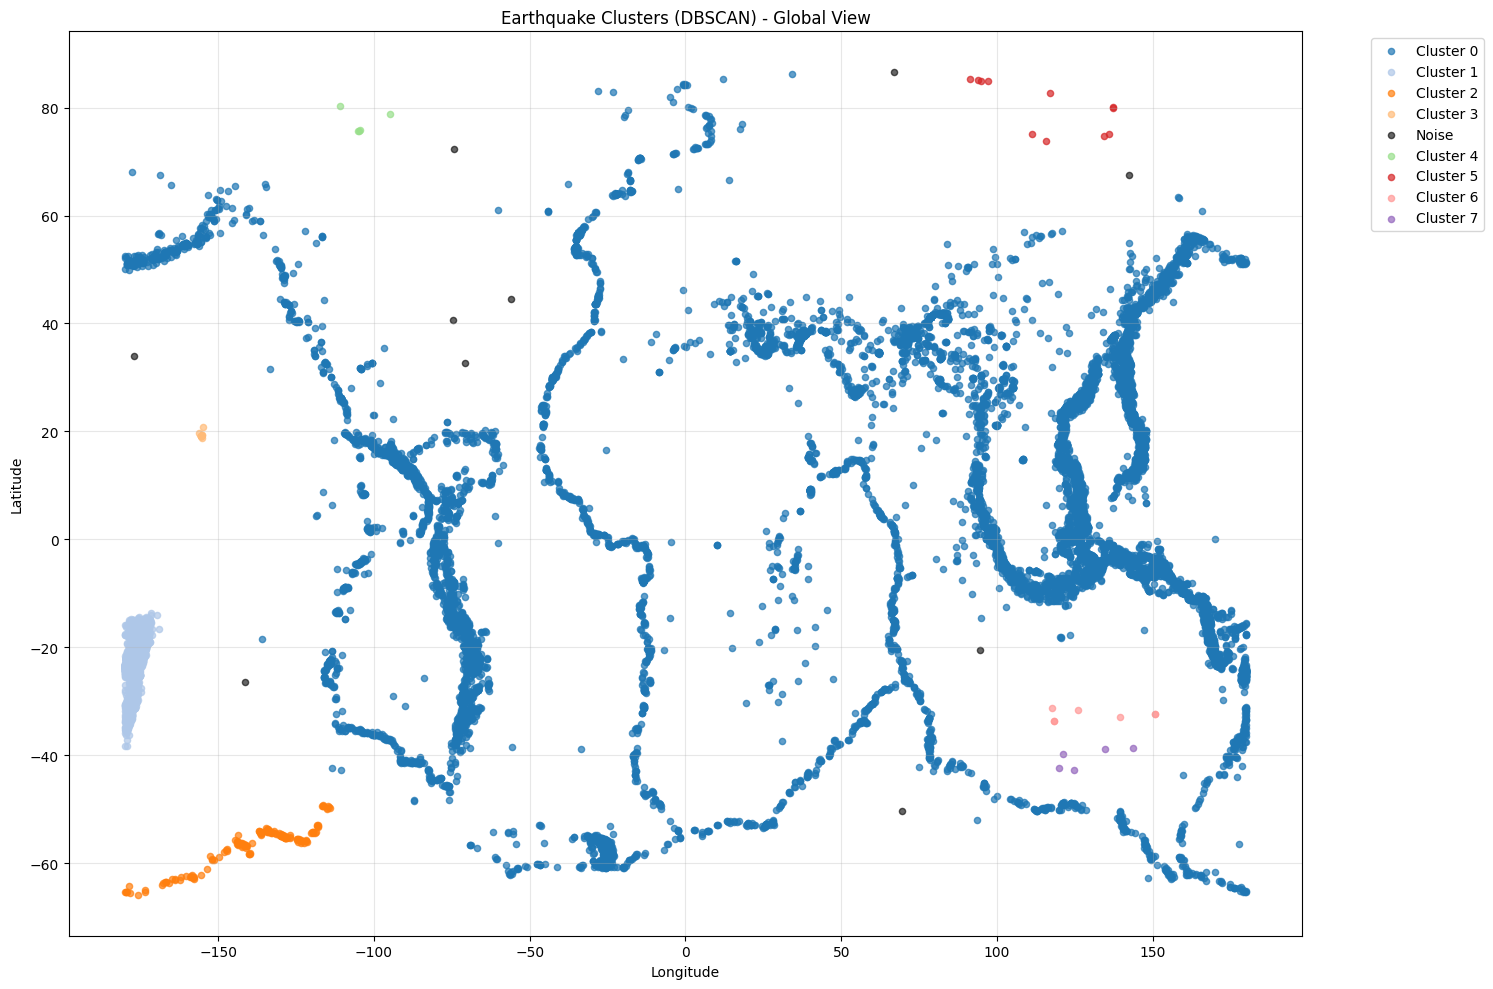


Cluster Statistics:
Number of clusters found: 8
Number of noise points: 10
Percentage of points classified as noise: 0.1%

Cluster sizes:
  Noise: 10 points
  Cluster 0: 17005 points
  Cluster 1: 2404 points
  Cluster 2: 161 points
  Cluster 3: 11 points
  Cluster 4: 5 points
  Cluster 5: 11 points
  Cluster 6: 7 points
  Cluster 7: 5 points


In [14]:
# Try to import and use folium for interactive mapping
import sys

try:
    import folium
    print("Folium imported successfully!")
    
    # Start map
    m = folium.Map(location=[0,0], zoom_start=2)

    # Colors for clusters
    colors = ['red','blue','green','purple','orange','darkred','lightred',
              'beige','darkblue','darkgreen','cadetblue','darkpurple','white',
              'pink','lightblue','lightgreen','gray','black','lightgray']

    # Add points to map
    for _, row in df.iterrows():
        cluster_id = row['cluster']
        color = 'black' if cluster_id == -1 else colors[cluster_id % len(colors)]
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            popup=f"Magnitude: {row['magnitude']}, Place: {row['place']}",
            color=color,
            fill=True,
            fill_color=color
        ).add_to(m)

    m.save("earthquake_clusters.html")
    print("Interactive map saved as earthquake_clusters.html")
    
except (ImportError, ModuleNotFoundError) as e:
    print(f"Folium not available ({e}). Creating enhanced static visualization instead...")
    
    # Enhanced static visualization
    plt.figure(figsize=(15, 10))
    
    # Create subplot for world map
    unique_clusters = df['cluster'].unique()
    colors_static = plt.cm.tab20(range(len(unique_clusters)))
    
    for i, cluster_id in enumerate(unique_clusters):
        cluster_data = df[df['cluster'] == cluster_id]
        if cluster_id == -1:
            # Noise points in black
            plt.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                       c='black', s=20, alpha=0.6, label='Noise')
        else:
            plt.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                       c=[colors_static[i]], s=20, alpha=0.7, 
                       label=f'Cluster {cluster_id}')
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Earthquake Clusters (DBSCAN) - Global View")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Additional statistics (works with or without folium)
print(f"\nCluster Statistics:")
unique_clusters = df['cluster'].unique()
print(f"Number of clusters found: {len(unique_clusters[unique_clusters != -1])}")
print(f"Number of noise points: {sum(df['cluster'] == -1)}")
print(f"Percentage of points classified as noise: {100 * sum(df['cluster'] == -1) / len(df):.1f}%")

# Show cluster sizes
cluster_counts = df['cluster'].value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"  Noise: {count} points")
    else:
        print(f"  Cluster {cluster_id}: {count} points")

🔹 Step 3: DBSCAN Parameter Analysis

In [15]:
# Test different DBSCAN parameters
import numpy as np
from sklearn.metrics import silhouette_score

# Prepare data
X = df[['latitude', 'longitude']].values
X_scaled = StandardScaler().fit_transform(X)

# Test different eps values
eps_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
min_samples_values = [3, 5, 7, 10]

results = []

print("Testing DBSCAN parameters...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Calculate silhouette score if we have clusters
        silhouette = -1
        if n_clusters > 1:
            try:
                silhouette = silhouette_score(X_scaled, labels)
            except:
                silhouette = -1
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(labels),
            'silhouette': silhouette
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nParameter tuning results:")
print(results_df.head(10))

# Find best parameters (balance between silhouette score and reasonable cluster count)
best_params = results_df[results_df['silhouette'] > 0].loc[results_df['silhouette'].idxmax()]
print(f"\nBest parameters based on silhouette score:")
print(f"eps: {best_params['eps']}, min_samples: {best_params['min_samples']}")
print(f"Clusters: {best_params['n_clusters']}, Noise ratio: {best_params['noise_ratio']:.2f}")
print(f"Silhouette score: {best_params['silhouette']:.3f}")

Testing DBSCAN parameters...

Parameter tuning results:
    eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
0  0.10            3          27       55     0.002803   -0.267100
1  0.10            5          16       98     0.004995   -0.131175
2  0.10            7          16      127     0.006473   -0.169457
3  0.10           10          14      165     0.008410   -0.144574
4  0.15            3          10       27     0.001376   -0.268811
5  0.15            5           6       45     0.002294   -0.047408
6  0.15            7           5       57     0.002905    0.015275
7  0.15           10           5       71     0.003619    0.015386
8  0.20            3           8        9     0.000459   -0.079471
9  0.20            5           8       10     0.000510   -0.079509

Best parameters based on silhouette score:
eps: 0.4, min_samples: 10.0
Clusters: 2.0, Noise ratio: 0.00
Silhouette score: 0.296

Parameter tuning results:
    eps  min_samples  n_clusters  n_noise  noise_ra

🔹 Step 4: Insights & Analysis

In [16]:
# Analyze earthquake clusters and provide insights
print("🌍 DBSCAN Earthquake Clustering Analysis")
print("=" * 50)

# Geographic analysis
print("\n📍 Geographic Distribution:")
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    if cluster_id == -1:
        print(f"\n🔸 Noise Points ({len(cluster_data)} earthquakes):")
        print("  - Scattered individual earthquakes")
        print("  - Not part of major seismic zones")
    else:
        print(f"\n🔸 Cluster {cluster_id} ({len(cluster_data)} earthquakes):")
        lat_range = f"{cluster_data['latitude'].min():.1f}° to {cluster_data['latitude'].max():.1f}°"
        lon_range = f"{cluster_data['longitude'].min():.1f}° to {cluster_data['longitude'].max():.1f}°"
        print(f"  - Latitude range: {lat_range}")
        print(f"  - Longitude range: {lon_range}")
        print(f"  - Average magnitude: {cluster_data['magnitude'].mean():.1f}")
        
        # Try to identify regions
        sample_places = cluster_data['place'].head(3).tolist()
        print(f"  - Sample locations: {sample_places}")

# Magnitude analysis
print(f"\n📊 Magnitude Analysis:")
print(f"Overall magnitude range: {df['magnitude'].min():.1f} - {df['magnitude'].max():.1f}")

for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    avg_mag = cluster_data['magnitude'].mean()
    if cluster_id == -1:
        print(f"Noise points average magnitude: {avg_mag:.1f}")
    else:
        print(f"Cluster {cluster_id} average magnitude: {avg_mag:.1f}")

# Temporal analysis
print(f"\n⏰ Temporal Distribution:")
print(f"Time span: {df['time'].min().strftime('%Y-%m-%d')} to {df['time'].max().strftime('%Y-%m-%d')}")

# Key insights
print(f"\n🔍 Key Insights:")
print(f"✅ DBSCAN successfully identified {len(df['cluster'].unique()) - 1} seismic zones")
print(f"✅ {100 * sum(df['cluster'] != -1) / len(df):.1f}% of earthquakes belong to clustered regions")
print(f"✅ Noise points ({100 * sum(df['cluster'] == -1) / len(df):.1f}%) represent isolated seismic events")
print(f"✅ Algorithm naturally identifies earthquake-prone regions without geographic knowledge")

# Why DBSCAN works well for earthquakes
print(f"\n🎯 Why DBSCAN is Perfect for Earthquake Data:")
print("🔸 Density-based clustering naturally identifies seismic zones")
print("🔸 Handles irregular cluster shapes (fault lines, tectonic boundaries)")  
print("🔸 Automatically identifies noise (isolated earthquakes)")
print("🔸 No need to specify number of clusters beforehand")
print("🔸 Robust to outliers (distant earthquakes won't distort clusters)")

🌍 DBSCAN Earthquake Clustering Analysis

📍 Geographic Distribution:

🔸 Noise Points (10 earthquakes):
  - Scattered individual earthquakes
  - Not part of major seismic zones

🔸 Cluster 0 (17005 earthquakes):
  - Latitude range: -65.4° to 86.3°
  - Longitude range: -180.0° to 180.0°
  - Average magnitude: 4.8
  - Sample locations: ['49 km W of Puerto, Chile', '86 km ENE of Kinablangan, Philippines', '124 km ESE of Kandrian, Papua New Guinea']

🔸 Cluster 1 (2404 earthquakes):
  - Latitude range: -38.3° to -13.6°
  - Longitude range: -180.0° to -168.8°
  - Average magnitude: 4.8
  - Sample locations: ['247 km ENE of Levuka, Fiji', '181 km WNW of Pangai, Tonga', '69 km E of Hihifo, Tonga']

🔸 Cluster 2 (161 earthquakes):
  - Latitude range: -65.8° to -49.3°
  - Longitude range: -179.8° to -114.2°
  - Average magnitude: 5.0
  - Sample locations: ['Pacific-Antarctic Ridge', 'Pacific-Antarctic Ridge', 'Pacific-Antarctic Ridge']

🔸 Cluster 3 (11 earthquakes):
  - Latitude range: 18.8° to 20.8